In [54]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
     coco_detection_yolo_format_train,
     coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
     DetectionMetrics_050,
     DetectionMetrics_050_095
)

from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

In [55]:

ROOT_DIR = os.getcwd()
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Helmet On','No Helmet']


In [56]:
dataset_params = {
    'train_images_dir': train_imgs_dir,
    'train_labels_dir': train_labels_dir,
    'val_images_dir'  : val_imgs_dir,
    'val_labels_dir'  : val_labels_dir,
    'test_images_dir' : test_imgs_dir,
    'test_labels_dir' : test_labels_dir,
    'classes'         : classes
}

In [57]:
#Global Parameters
EPOCHS = 20
BATCH_SIZE = 16
WORKERS = 2

In [58]:
#Visualize Ground Truth Images
colors = np.random.uniform(0, 255, size =(len(classes), 3))
print(colors)

In [59]:
#Function to convewrt bounding boxes in YOLO format to xmin, ymin, xmax, ymax
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2,bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2,bboxes[1]+bboxes[3]/2

    return xmin, ymin, xmax, ymax
    

In [61]:
#Function to Plot images with Bounding Boxes
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images,all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15,12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2,4, i+1) #Visualize 2*2 grid of images
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

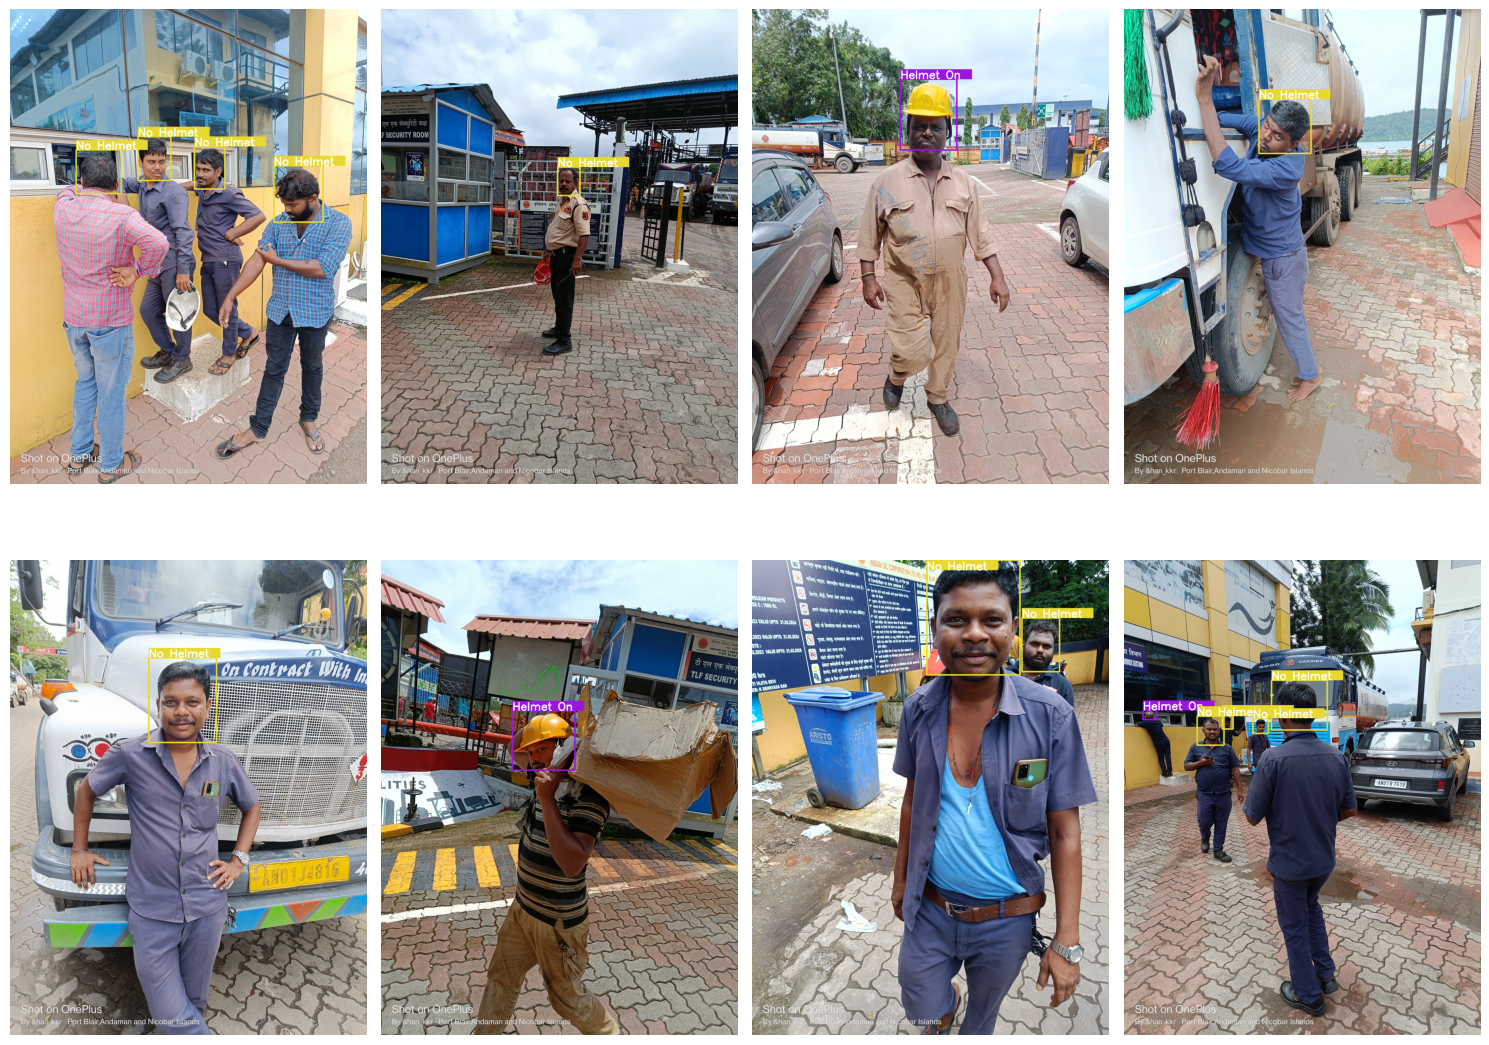

In [62]:
plot(image_path = os.path.join(train_imgs_dir),
     label_path = os.path.join(train_labels_dir),
     num_samples = 8,
    )


In [63]:
#Train & Val Data Preparation For Training
train_data = coco_detection_yolo_format_train(
    dataset_params ={
        'data_dir':   ROOT_DIR,
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params ={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params ={
        'data_dir':   ROOT_DIR,
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params ={
        'batch_size': BATCH_SIZE,
        'num_workers': WORKERS
    }
)

Indexing dataset annotations: 100%|███████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 2989.53it/s]


In [65]:
#Transformations & Augmentations of the dataset
train_data.dataset.transforms

In [67]:
train_data.dataset.transforms[0]

In [68]:
train_data.dataset.transforms.pop(2)

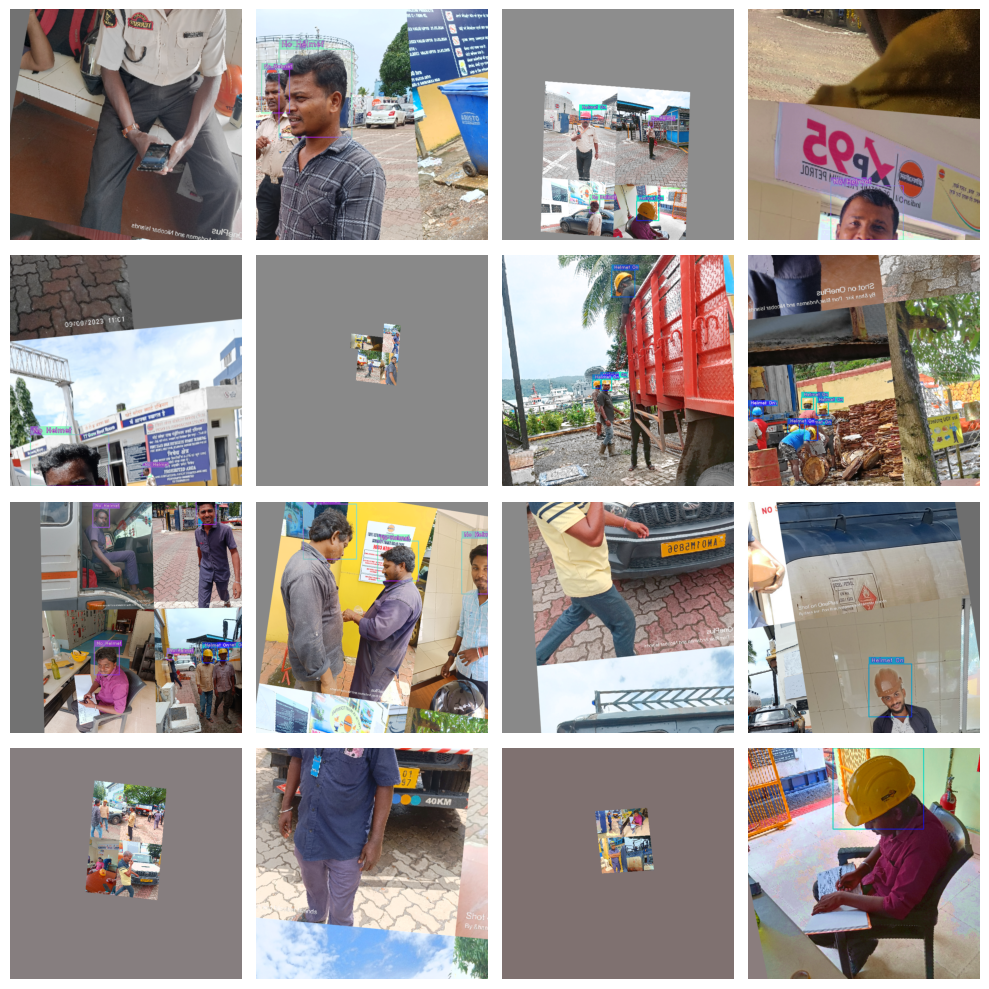

In [69]:
train_data.dataset.plot(plot_transformed_data = True)

In [79]:
train_params = {
    'silent_mode' : False,
    "average_best_models" : False,
    "warmup_mode" : "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr" : 5e-4,
    "lr_mode" : "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer" : "Adam",
    "optimizer_params" : {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn" : True,
    "ema" : True,
    "ema_params" : {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs" : EPOCHS,
    "mixed_precision" : True,
    "loss" : PPYoloELoss(
        use_static_assigner=False,
        num_classes = len(dataset_params['classes']),
        reg_max = 16
    ),
    "valid_metrics_list": [
    DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params["classes"]),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7,
        ),
    ),
    DetectionMetrics_050_095(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params["classes"]),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7,
        ),
    ),
],
    "metric_to_watch" : 'mAP@0.50:0.95'
}

D:\GRE College Selection\RWTH Aachen_Robotics\Object Detection Project\Dataset\.venv\lib\site-packages\super_gradients\training\losses\ppyolo_loss.py:669: DeprecationWarning: A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs
  warnings.warn(


In [80]:
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]

In [81]:
CHECKPOINT_DIR = 'checkpoints'

In [ ]:
#Model Training
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name = model_to_train,
        ckpt_root_dir = CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params["classes"]),
        pretrained_weights = None
    )

    trainer.train(
        model = model,
        training_params = train_params,
        train_loader = train_data,
        valid_loader = val_data
    )
        

D:\GRE College Selection\RWTH Aachen_Robotics\Object Detection Project\Dataset\.venv\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
D:\GRE College Selection\RWTH Aachen_Robotics\Object Detection Project\Dataset\.venv\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
Train epoch 0:  13%|█▎        | 8/62 [00:31<02:13,  2.47s/it, PPYoloELoss/loss=4.1, PPYoloELo

In [ ]:
which python
